<a href="https://colab.research.google.com/github/Bingboom/Getting-started-in-Technical-Writing/blob/main/Sentiment_Analysis_with_Ludwig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis with Ludwig**

**Authors:** [Piero Molino](https://w4nderlu.st/), [Elias Castro Hernandez](https://www.linkedin.com/in/ehcastroh/), [Kanishk Kalra](https://kanishk16.github.io/), [Michael Zhu](https://michaelbzhu.github.io/)

**About:** 
[Ludwig](https://ludwig-ai.github.io/ludwig-docs/index.html) is a user friendly deep learning toolbox that allows users to train and test deep learning models on a variety of applications, including many natural language processing ones like sentiment analysis. 

This notebook shows the ease with which production-ready models, from simple to the state-of-the-art, can be trained and tested in just a few lines of code using Ludwig and how to use Ludwig's visualization module to analyze them. All is done by simply defining inputs, outputs and few additional parameters without any need of pre-processing or implementing models and machine learning code from scratch.


###**Overview**

Let's quickly introduce the problem that we'd be working upon to demonstrate how one can use Ludwig to tackle it. We'll be approaching one of the most common and popular tasks in Natural Language Processing (NLP), Sentiment Analysis. Sentiment Analysis is one of the tasks in NLP that involves classifying a piece of text with respect to the polarity of the sentiment it conveys. Usually, sentiment analysis datasets come either with binary labels indicating positive or negative sentiment or with more graded annotations. The dataset that we are going to use for this notebook/tutorial is the well known [Stanford Sentiment Treebank (SST)](https://nlp.stanford.edu/sentiment/).

SST is a sentence-level corpus of 10,662 labeled sentences created via a crowd-sourced effort to manually label the original [Rotten Tomatoes Dataset (Pang & Lee 2005)](http://www.cs.cornell.edu/people/pabo/movie-review-data/), which contains sentences from movie reviews with labels for every single phrase in each of the branches of the [parse trees](https://medium.com/basecs/grammatically-rooting-oneself-with-parse-trees-ec9daeda7dad) for all the sentences.

SST corpus comprises of both:
* SST-2 annotations -- negative (0), neutral (1), and positive (2)
* SST-5 annotations -- very negative (0), negative (1), neutral (2), positive (3), and very positive (4)

![Example Parse Tree for a Simple Sentence](https://www.researchgate.net/profile/Manish_Munikar/publication/334636635/figure/fig1/AS:783866700787713@1563899793879/A-sample-sentence-from-the-Stanford-Sentiment-Treebank3.png "Example of a Parsing Tree")

Example parse tree from [Socher et al. (2013)](https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf).

We will use just the phrases and their annotations, discarding the parse tree information.
Let's start the setup by installing Ludwig using pip. As we are going to work with text and visualize our model performances, let's also install the relevant subpackages.

## **Setup**

#### **Install Ludwig**



In [ ]:
# install processing packages (ignore the errors generated due to the upgradation of some pkgs.)
!pip install --quiet ludwig[text,viz]

     |████████████████████████████████| 235kB 7.8MB/s 
     |████████████████████████████████| 9.5MB 48.7MB/s 
     |████████████████████████████████| 706kB 47.9MB/s 
     |████████████████████████████████| 12.7MB 254kB/s 
     |████████████████████████████████| 1.8MB 44.9MB/s 
     |████████████████████████████████| 1.2MB 48.5MB/s 
     |████████████████████████████████| 696kB 51.8MB/s 
     |████████████████████████████████| 460kB 57.9MB/s 
     |████████████████████████████████| 9.1MB 39.7MB/s 
     |████████████████████████████████| 1.1MB 46.4MB/s 
     |████████████████████████████████| 890kB 44.5MB/s 
     |████████████████████████████████| 2.9MB 46.4MB/s 
     |████████████████████████████████| 788kB 50.4MB/s 
     |████████████████████████████████| 122kB 60.8MB/s 
     |████████████████████████████████| 358kB 53.9MB/s 
     |████████████████████████████████| 368kB 61.0MB/s 
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit


**Note:** Since Colab is ran entirely on a server, the errors generated above due to upgrading some of the packages will have no consequence in the functioning of this walkthrough and can be ignored. 


Moving on to preparing our environment by importing some necessary packages:

#### **Prepare Environment**

In [ ]:
import ludwig                                               
from ludwig.api import LudwigModel  
from ludwig.visualize import learning_curves, compare_performance, compare_classifiers_predictions
from ludwig.utils.data_utils import load_json
from ludwig.utils.nlp_utils import load_nlp_pipeline, process_text

# data and visualization
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# auxiliary packages
import os
import yaml                                       
import logging                                    
import json
from tqdm.notebook import trange                           

/usr/local/lib/python3.7/dist-packages/typeguard/__init__.py:804: UserWarning: no type annotations present -- not typechecking tensorflow_addons.layers.max_unpooling_2d.MaxUnpooling2D.__init__
  warn('no type annotations present -- not typechecking {}'.format(function_name(func)))


#### **Verify GPU availability in Colab**


In [ ]:
# sanity check for tensorflow utilizing the GPU
import tensorflow as tf               

if tf.config.list_physical_devices('GPU'):
  print(tf.config.list_physical_devices('GPU')[-1])
else:
  raise SystemError('Runtime not switched to GPU')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


**Note:** If you get the following error,

```
SystemError: Runtime not switched to GPU
```
It means that you didn't enable the free Colab GPU.
We recommend that you enable the free GPU by going:
> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

#### **Load and Preprocess Dataset**

We will be using [Torchtext](https://pytorch.org/text/) to download the SST dataset.

The SST has two versions:
1.  **SST-2** which has three labels: negative, neutral, and positive. 
2.  **SST-5 (SST-fine-grained)** which has five labels: very negative, negative, neutral, positive, and very positive.

We will retrieve SST-5 from `torchtext.datasets.SST` by setting `fine_grained=True`, but you can run the notebook with SST-2 as well by setting `fine_grained=False`.

In [ ]:
# dataset utils
from torchtext import data                                  
from torchtext import datasets   

In [ ]:
# pick either SST-2 (False) or SST-5 (True)
fine_grained = True

if(fine_grained):
  # define SST-5 classes for sentiment labels
  idx2class = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
  class2idx = {cls: idx for idx, cls in enumerate(idx2class)}
else:
  # define SST-2 classes for sentiment labels
  idx2class = ["negative", "neutral", "positive"]
  class2idx = {cls: idx for idx, cls in enumerate(idx2class)}

text_field = data.Field(sequential=False)
label_field = data.Field(sequential=False)  # False indicates no tokenization

# obtain pre-split data into training, validation and testing sets
train_split, val_split, test_split = datasets.SST.splits(
    text_field,
    label_field,
    fine_grained=fine_grained,
    train_subtrees=True        # use all subtrees in the training set
)

Ludwig allows a variety of formats to be processed, but for simplicity let's transform the SST-5 dataset into a Pandas DataFrame.

In [ ]:
# obtain texts and labels from the training set
x_train = []
y_train = []
for i in trange(len(train_split), desc='Train'):
    x_train.append(vars(train_split[i])["text"])
    y_train.append(class2idx[vars(train_split[i])["label"]])

# obtain texts and labels from the validation set
x_val = []
y_val = []
for i in trange(len(val_split), desc='Validation'):
    x_val.append(vars(val_split[i])["text"])
    y_val.append(class2idx[vars(val_split[i])["label"]])

# obtain texts and labels from the test set
x_test = []
y_test = []
for i in trange(len(test_split), desc='Test'):
    x_test.append(vars(test_split[i])["text"])
    y_test.append(class2idx[vars(test_split[i])["label"]])

# create three separate dataframes
train_data = pd.DataFrame({"text": x_train, "label": y_train})
validation_data = pd.DataFrame({"text": x_val, "label": y_val})
test_data = pd.DataFrame({"text": x_test, "label": y_test})

## **Exploratory data analysis**

After transformation into DataFrames, Now let's inspect it, both to get a flavor of its content and to figure out how balanced it is.

In [ ]:
# preview sample of data with class labels
labels = [idx2class[int(id)] for id in train_data['label']]

train_data_preview = train_data.drop(columns='label').assign(class_id=train_data['label'], class_label=labels)

train_data_preview.head()

,text,class_id,class_label
0,"The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .",3,positive
1,The Rock,2,neutral
2,The,2,neutral
3,Rock,2,neutral
4,"is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .",4,very positive


Let's look at the class distribution of the training set to get an intuition of its balance.

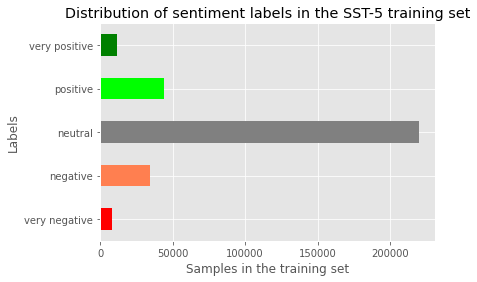

In [ ]:
# plotting look
plt.style.use('ggplot')

fig, ax = plt.subplots()

if fine_grained:
  ax.set_title(f'Distribution of sentiment labels in the SST-5 training set')
  ax = train_data['label'].value_counts(sort=False).plot(kind='barh', color=['red', 'coral', 'grey', 'lime', 'green'])
else:
  ax.set_title(f'Distribution of sentiment labels in the SST-2 training set')
  ax = train_data['label'].value_counts(sort=False).plot(kind='barh', color=['red','green'])

# axes info
ax.set_xlabel('Samples in the training set')
ax.set_ylabel('Labels')
ax.set_yticklabels(tuple(idx2class))
ax.grid(True)
plt.show()

The plot shows how the neutral class is by far the most frequent in the dataset. The reason for this is that we are using all phrases in the reviews and many of them are neutral despite being part of more polarized reviews.

A word cloud can moreover give us an overview of the content of the dataset by showing the words appearing in it most frequently.

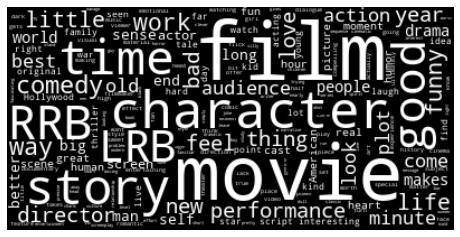

In [ ]:
processed_train_data = process_text(' '.join(train_data['text']),
                                    load_nlp_pipeline('en'),
                                    filter_punctuation=True,
                                    filter_stopwords=True)

wordcloud = WordCloud(background_color='black', collocations=False,
                      stopwords=STOPWORDS).generate(' '.join(processed_train_data))

plt.figure(figsize=(8,8))
plt.imshow(wordcloud.recolor(color_func=lambda *args, **kwargs:'white'), interpolation='bilinear')
plt.axis('off')
plt.show()

## **Model Selection - Baseline to SOTA**

In order to obtain a model that predicts the sentiment of the movie reviews in SST, we need to train a multi-class text classifier. We are going to train a few models to know how well they perform on the sentiment analysis task using this dataset and compare them.

We will be exploring the following models:

I.   Parallel CNN, similar to a WordCNN, one of the first successful deep learning models applied to language tasks, 

II. Bidirectional LSTM and finally,

III. A pre-trained BERT model.

We chose these models because they are different in terms of complexity and computational requirements.

Ludwig provides more models architectures to play with, and even more can be added very easily.
In the first two models we are going to use pre-trained word embeddings, so let's quickly introduce them.

#### **What are pre-trained embeddings and why are they useful?**

Word vectors,or embeddings, are a way of representing words with a fixed-size dense vector. These fixed-size vectors are learned to represent words based on the contexts in which they appear in a reference corpus, which is usually huge in size. They can be trained using different algorithms such as word2vec or GloVe. 

When used as the first layer of a neural networks, pre-trained embeddings have been shown to [provide a boost in sentiment analysis performance](https://arxiv.org/pdf/1408.5882v2.pdf), as they transfer information learned on bigger corpora.  

In [ ]:
# extracting the GloVe embeddings takes ~7 minutes with a decent internet connection

# download pre-trained embeddings GloVe
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

# unzip to glove dir 
!unzip /content/glove.6B.zip -d glove/

### **Parallel CNN**

The Parallel CNN encoder is a more general version of the WordCNN model presented in [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882) by Yoon Kim.
The paper proposes to use convolutional layers with filters of different sizes in parallel to perform sentence classification and showed good results on sentence classification tasks like sentiment analysis and question classification. 
It was also among the first papers to use pre-trained embeddings, which has then become a common practice. 

For a detailed explanation of CNNs refer to [this article](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/) or the explanation from [Stanford CS231n](https://cs231n.github.io/convolutional-networks/). Also, for CNNs in context to text refer to this [blog](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/) or [A Primer on Neural Network Models for NLP](https://arxiv.org/pdf/1510.00726.pdf), Section 9 by Yoav Goldberg.

#### **Building Parallel CNN Using Ludwig**

To build a Ludwig model, we first need to define a configuration.

The configuration contains information about the inputs to the models, its outputs, training and preprocessing parameters and hyperparameters to optimize. Given a configuration, Ludwig assembles a model depending on the data type of inputs and outputs.

Since our dataset contains an input text and an output category, our configuration will contain one input feature of type text and one output feature of type category.

When defining input features, we have to provide a list of dictionaries, one for each feature. Each dictionary should contain a name (the name of the column in the DataFrame that contains it) and a type, in our case text. We can also specify several additional optional parameters:

* the level of representation (e.g. words or characters in the text -- `'level': 'word'`).
* the type of neural network architecture we want to use -- `'encoder': 'parallel_cnn'` and its parameters (number of filters with their sizes, number of fully-connected layers with their sizes)
* the word embeddings to load, their size, the vocabulary to use..

Similarly, we can specify several training parameters in the training section as:

* learning rate or if to use decay or not-- `'learning_rate': 0.001`, `'decay': True`.
* the output feature to use for validation -- `'validation_field': 'label'`.
* the metric to use for validation and early stopping -- `'validation_metric': 'accuracy'`.

Though we have briefly looked over the list of configurable parameters, there are a lot more. Refer to the [User Guide](https://ludwig-ai.github.io/ludwig-docs/user_guide/) to get a complete list of them. Additionally, check the [Examples](https://ludwig-ai.github.io/ludwig-docs/examples/) page for examples of simple configurations for several machine learning tasks other than text classification. 

In [ ]:
# Parallel CNN model with pretrained_embeddings on SST-5
config = {
    'input_features': [{ 
        'name': 'text',
        'type': 'text', 
        'level': 'word', 
        'encoder': 'parallel_cnn',
        'pretrained_embeddings': '/content/glove/glove.6B.300d.txt',
        'embedding_size': 300,
        'preprocessing': { 'word_vocab_file': '/content/glove/glove.6B.300d.txt' }
    }],
    'output_features': [{'name': 'label', 'type': 'category'}],
    'training': {
        'decay': True,
        'learning_rate': 0.001,
        'validation_field': 'label',
        'validation_metric': 'accuracy'
    }
}

After defining our configuration, we just need to create a `LudwigModel` instance and train it using the DataFrames previously obtained.

In [ ]:
print("Instantiating LudwigModel...")
parallel_cnn = LudwigModel(config, logging_level=logging.DEBUG)

print("Training model...")
train_stats_parallel_cnn, _, _ = parallel_cnn.train(
    training_set=train_data,
    validation_set=validation_data,
    test_set=test_data,
    model_name='parallel_cnn',
    skip_save_processed_input=True
)

Instantiating LudwigModel...
Training model...
Experiment name: api_experiment
Model name: parallel_cnn
Output directory: results/api_experiment_parallel_cnn_1


ludwig_version: '0.3.2-dev0'
command: ('/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py -f '
 '/root/.local/share/jupyter/runtime/kernel-f9d5f10e-a85f-4f6e-840b-85a0c4c6b738.json')
random_seed: 42
data_format: "<class 'pandas.core.frame.DataFrame'>"
config: {   'combiner': {'type': 'concat'},
    'input_features': [   {   'column': 'text',
                              'embedding_size': 300,
                              'encoder': 'parallel_cnn',
                              'level': 'word',
                              'name': 'text',
                              'preprocessing': {   'word_vocab_file': '/content/glove/glove.6B.300d.txt'},
                              'pretrained_embeddings': '/content/glove/glove.6B.300d.txt',
                              'proc_column': 'text_mBnHBS',
                      

#### **Visualizing and Interpreting Parallel CNN Results**

We successfully trained a Parallel CNN using Ludwig and the training statistics were returned in the `train_stats_parallel_cnn` variable.

Let's visualize these statistics to better understand the training process. Ludwig makes it easy to visualize the learning curves with different metrics (the *loss*, the *accuracy* and *hits at k*) by calling the `learning_curves` function.

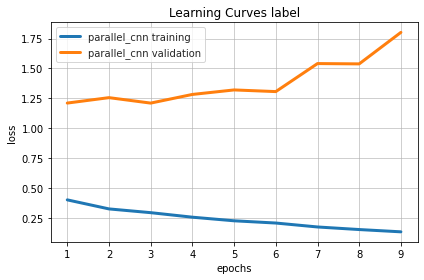

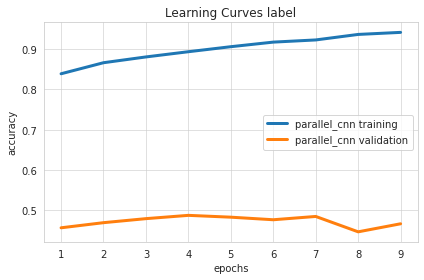

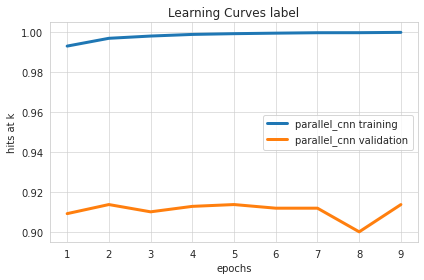

In [ ]:
# visualizing the training results  
learning_curves(train_stats_parallel_cnn, output_feature_name='label', model_names='parallel_cnn')

The above graphs showing the learning curves with different metrics (the *loss* itself, the *accuracy*, and *hits at k*) demonstrate how the model achieves its maximum performance on the validation set (validation accuracy of 48.7% at epoch 4) and plateauing thereafter, although most of the training improvement was already obtained in the first two epochs.

We do observe a significant gap between the training and validation curves. This is indicative of the model underfitting. Hence, we must try some other model which captures more variance.

### **Bidirectional LSTM (Long Short Term Memory)**



Parallel CNNs perform well on NLP tasks and have the advantage of being fast to train, but may have problems dealing with language compositionality and long  dependencies, as suggested in a [paper](https://www.aclweb.org/anthology/D18-1109.pdf) by Yi Yang.  

By comparison, [Recurrent Neural Network (RNN)](https://www.deeplearningbook.org/contents/rnn.html) provides an architecture that accounts for language compositionality as well as long term dependencies in language -- with its recurrent structure,  which is well suited for sequences. Though RNNs provide flexibility in processing variable sized inputs, they are succeptible to the vanishing gradient problem which limits the length of the dependencies. 

Long Short Term Memory (LSTM) is a type of RNN that uses a different cell as the operation to apply to each time step. This modified cell, through the use of a memory that is written to and read from, mitigates the vanishing gradient problem.

In our model, we make the LSTM bidirectional by having a separate layer for each direction (left→right and right→left) and then concatenating their outputs.

For more details on RNNs refer to the [paper](https://crl.ucsd.edu/~elman/Papers/cs-counter.pdf) by Paul Rodriguez, Janet Wiles & Jeffrey L. Elman and for LSTMs refer to the [paper](https://www.bioinf.jku.at/publications/older/2604.pdf) by Hochreiter and Schmidhuber.

#### **Building Bidirectional LSTM Using Ludwig**

Just as we defined a configuration for Parallel CNN, we follow the exact same pattern to define a configuration for a bidirectional LSTM but, changing and adding a few parameters to input_features We change the encoder to RNN (`'encoder': 'rnn'`) with an LSTM cell (`'cell_type': 'lstm'`), that is applied in both directions (`'bidirectional': True`) and keep the other parameters the same.

In [ ]:
# config for bidrectional LSTM
config = {
    'input_features': [{
        'name': 'text',
        'type': 'text',
        'level': 'word',
        'encoder': 'rnn',
        'cell_type': 'lstm',
        'bidirectional': True,
        'pretrained_embeddings': '/content/glove/glove.6B.300d.txt',
        'embedding_size': 300,
        'preprocessing': {'word_vocab_file': '/content/glove/glove.6B.300d.txt'}
    }],
    'output_features': [{'name': 'label', 'type': 'category'}],
    'training': {
        'decay': True,
        'learning_rate': 0.001,
        'validation_field': 'label',
        'validation_metric': 'accuracy'
    }
}

print("Instantiating LudwigModel...")
bi_lstm = LudwigModel(config, logging_level=logging.DEBUG)

print("Training Model...")
train_stats_bi_lstm, _, _ = bi_lstm.train(
    training_set=train_data,
    validation_set=validation_data,
    test_set=test_data,
    model_name='bi_lstm',
    skip_save_processed_input=True
)

Instantiating LudwigModel...
Training model...
Experiment name: api_experiment
Model name: bi_lstm
Output directory: results/api_experiment_bi_lstm


ludwig_version: '0.3.2-dev0'
command: ('/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py -f '
 '/root/.local/share/jupyter/runtime/kernel-f9d5f10e-a85f-4f6e-840b-85a0c4c6b738.json')
random_seed: 42
data_format: "<class 'pandas.core.frame.DataFrame'>"
config: {   'combiner': {'type': 'concat'},
    'input_features': [   {   'bidirectional': True,
                              'cell_type': 'lstm',
                              'column': 'text',
                              'embedding_size': 300,
                              'encoder': 'rnn',
                              'level': 'word',
                              'name': 'text',
                              'preprocessing': {   'word_vocab_file': '/content/glove/glove.6B.300d.txt'},
                              'pretrained_embeddings': '/content/glove/glove.6B.300d.txt',

#### **Visualizing and Interpreting Bidirectional LSTM's Results**
Like we did for the ParallelCNN, let's visualize the learning curves.

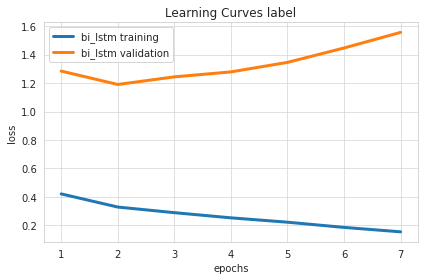

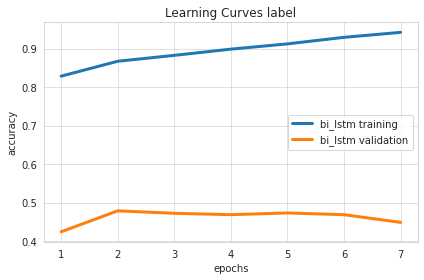

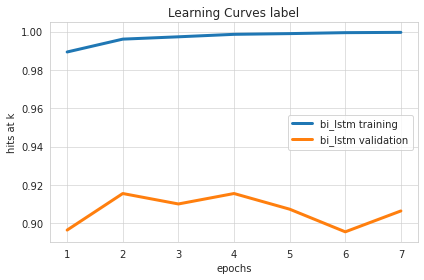

In [ ]:
# visualizing the training results  
learning_curves(train_stats_bi_lstm, output_feature_name='label', model_names='bi_lstm')

Just a glance over the Bi-LSTM's learning curves helps us identify that the model achieved a maximum validation accuracy of 49.3% on epoch 2.
We observe that the performance achieved by the Bi-LSTM is slightly higher than the Parallel CNN. Depending on our deployment constraints, the added computation cost of the Bi-LSTM may or may not be worth the improved performance. There is still scope for improvement that leads us to the last model in our list, BERT.

### **BERT**

BERT is a state-of-the-art model introduced in [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/pdf/1810.04805.pdf) by Devlin et al. (2019), that uses the Transformer architecture  [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) by Vaswani et al. BERT is a family of models made of a deep stack of self-attention-based transformer layers pre-trained using a Masked Language Model objective over a large corpus, which consists in reading a sentence from the corpus, masking-out some words from it and teaching the model to predict the masked words back. Fine-tuning the pre-trained BERT representations on specific datasets allows us to achieve close to state-of-the-art performance in several sentence-level and token-level tasks.

#### **Building BERT Using Ludwig**

There's no major difference between Ludwig configuration for BERT and the ones we defined above for the Parallel CNN and bi-LSTM. The only minor changes are in the `input_features` and the training parameters.

In the `input_features`, we change the encoder to BERT (`'encoder': 'bert'`) and remove all the embedding related parameters, not needed for this type of architecture. All the other parameters are kept the same for this section. While fine-tuning a BERT encoder, we suggest using a smaller learning rate (`'learning_rate': 0.00002`) and smaller batch size(`'batch_size': 16`) to avoid out-of-memory issues because of the high memory consumption of BERT. Since BERT is larger than the previous models we trained and takes a lot of time per epoch (~1.25 hrs/epoch), we recommend setting the number of epochs to 2 (`'epochs': 2`) when working on Colab as it is sufficient to achieve good results on SST and avoids loss of metadata in case Colab gets disconnected.

In [ ]:
config = {
    'input_features': [{
        'name': 'text', 
        'type': 'text',  
        'encoder': 'bert'
    }],  
    'output_features': [{'name': 'label', 'type': 'category'}],    
    'training': {
        'batch_size': 16,
        'decay': True,
        'trainable': True,
        'learning_rate': 0.00002,
        'epochs': 2
    }
}
 
print("Instantiating LudwigModel...")
bert = LudwigModel(config, logging_level=logging.DEBUG)
 
print("Training Model...")
train_stats_bert, _, _ = bert.train(
    training_set=train_data, 
    validation_set=validation_data, 
    test_set=test_data,    
    model_name='bert',
    skip_save_processed_input=True
    )

Instantiating model...
Training model...
Experiment name: api_experiment


INFO:ludwig.api:Experiment name: api_experiment


Model name: Bert


INFO:ludwig.api:Model name: Bert


Output directory: results/api_experiment_Bert_0


INFO:ludwig.api:Output directory: results/api_experiment_Bert_0


INFO:ludwig.api:



ludwig_version: '0.3.3'


INFO:ludwig.api:ludwig_version: '0.3.3'


command: ('/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py -f '
 '/root/.local/share/jupyter/runtime/kernel-5ccb903f-9170-4453-9449-244d8e520a57.json')


INFO:ludwig.api:command: ('/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py -f '
 '/root/.local/share/jupyter/runtime/kernel-5ccb903f-9170-4453-9449-244d8e520a57.json')


random_seed: 42


INFO:ludwig.api:random_seed: 42


data_format: "<class 'pandas.core.frame.DataFrame'>"


INFO:ludwig.api:data_format: "<class 'pandas.core.frame.DataFrame'>"


config: {   'combiner': {'type': 'concat'},
    'input_features': [   {   'column': 'text',
                              'encoder': 'bert',
                              'level': 'word',
                              'name': 'text',
                              'pretrained_model_name_or_path': 'bert-base-uncased',
                              'proc_column': 'text_mZFLky',
                              'tied': None,
                              'type': 'text'}],
    'output_features': [   {   'column': 'label',
                               'dependencies': [],
                               'loss': {   'class_similarities_temperature': 0,
                                           'class_weights': 1,
                                           'confidence_penalty': 0,
                                           'labels_smoothing': 0,
                                           'robust_lambda': 0,
                                           'type': 'softmax_cross_entropy',
             

INFO:ludwig.api:config: {   'combiner': {'type': 'concat'},
    'input_features': [   {   'column': 'text',
                              'encoder': 'bert',
                              'level': 'word',
                              'name': 'text',
                              'pretrained_model_name_or_path': 'bert-base-uncased',
                              'proc_column': 'text_mZFLky',
                              'tied': None,
                              'type': 'text'}],
    'output_features': [   {   'column': 'label',
                               'dependencies': [],
                               'loss': {   'class_similarities_temperature': 0,
                                           'class_weights': 1,
                                           'confidence_penalty': 0,
                                           'labels_smoothing': 0,
                                           'robust_lambda': 0,
                                           'type': 'softmax_cross_entropy

tf_version: '2.4.1'


INFO:ludwig.api:tf_version: '2.4.1'


INFO:ludwig.api:



Using training dataframe


INFO:ludwig.data.preprocessing:Using training dataframe


Building dataset (it may take a while)


INFO:ludwig.data.preprocessing:Building dataset (it may take a while)


Training set: 318582


INFO:ludwig.api:Training set: 318582


Validation set: 1101


INFO:ludwig.api:Validation set: 1101


Test set: 2210


INFO:ludwig.api:Test set: 2210


DEBUG:ludwig.api:


╒═══════╕


DEBUG:ludwig.api:╒═══════╕


│ MODEL │


DEBUG:ludwig.api:│ MODEL │


╘═══════╛


DEBUG:ludwig.api:╘═══════╛


DEBUG:ludwig.api:


Input text feature text


DEBUG:ludwig.models.ecd:Input text feature text
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Combiner concat


DEBUG:ludwig.models.ecd:Combiner concat


 concat_combiner_6


DEBUG:ludwig.combiners.combiners: concat_combiner_6


Output category feature label


DEBUG:ludwig.models.ecd:Output category feature label


 output feature fully connected layers


DEBUG:ludwig.features.base_feature: output feature fully connected layers


  FCStack


DEBUG:ludwig.features.base_feature:  FCStack


 classifier_6


DEBUG:ludwig.decoders.generic_decoders: classifier_6


  Dense


DEBUG:ludwig.decoders.generic_decoders:  Dense


INFO:ludwig.utils.print_utils:


╒══════════╕


INFO:ludwig.utils.print_utils:╒══════════╕


│ TRAINING │


INFO:ludwig.utils.print_utils:│ TRAINING │


╘══════════╛


INFO:ludwig.utils.print_utils:╘══════════╛


INFO:ludwig.utils.print_utils:



Epoch 1


INFO:ludwig.models.trainer:
Epoch 1


Training:   0%|          | 0/19912 [00:00<?, ?it/s]

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Training: 100%|█████████▉| 19911/19912 [1:31:13<00:00,  3.64it/s]

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Evaluation train:   0%|          | 0/19912 [00:00<?, ?it/s]

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Evaluation train: 100%|█████████▉| 19911/19912 [27:59<00:00, 11.90it/s]

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Evaluation vali :  97%|█████████▋| 67/69 [00:05<00:00, 11.88it/s]

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Evaluation test :  99%|█████████▊| 137/139 [00:11<00:00, 11.78it/s]

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Evaluation test : 100%|██████████| 139/139 [00:12<00:00, 10.88it/s]
Took 1h 59m 38.7231s


INFO:ludwig.models.trainer:Took 1h 59m 38.7231s


╒═════════╤════════╤════════════╤═════════════╕
│ label   │   loss │   accuracy │   hits_at_k │
╞═════════╪════════╪════════════╪═════════════╡
│ train   │ 0.3944 │     0.8411 │      0.9959 │
├─────────┼────────┼────────────┼─────────────┤
│ vali    │ 1.0797 │     0.5268 │      0.9582 │
├─────────┼────────┼────────────┼─────────────┤
│ test    │ 1.1248 │     0.4937 │      0.9561 │
╘═════════╧════════╧════════════╧═════════════╛


INFO:ludwig.models.trainer:╒═════════╤════════╤════════════╤═════════════╕
│ label   │   loss │   accuracy │   hits_at_k │
╞═════════╪════════╪════════════╪═════════════╡
│ train   │ 0.3944 │     0.8411 │      0.9959 │
├─────────┼────────┼────────────┼─────────────┤
│ vali    │ 1.0797 │     0.5268 │      0.9582 │
├─────────┼────────┼────────────┼─────────────┤
│ test    │ 1.1248 │     0.4937 │      0.9561 │
╘═════════╧════════╧════════════╧═════════════╛


╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.3970 │
├────────────┼────────┤
│ vali       │ 1.1598 │
├────────────┼────────┤
│ test       │ 1.1657 │
╘════════════╧════════╛


INFO:ludwig.models.trainer:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.3970 │
├────────────┼────────┤
│ vali       │ 1.1598 │
├────────────┼────────┤
│ test       │ 1.1657 │
╘════════════╧════════╛


Validation loss on combined improved, model saved


INFO:ludwig.models.trainer:Validation loss on combined improved, model saved


INFO:ludwig.models.trainer:



Epoch 2


INFO:ludwig.models.trainer:
Epoch 2


Evaluation test : 100%|██████████| 139/139 [00:11<00:00, 11.86it/s]
Took 1h 59m 44.4962s


INFO:ludwig.models.trainer:Took 1h 59m 44.4962s


╒═════════╤════════╤════════════╤═════════════╕
│ label   │   loss │   accuracy │   hits_at_k │
╞═════════╪════════╪════════════╪═════════════╡
│ train   │ 0.2914 │     0.8847 │      0.9983 │
├─────────┼────────┼────────────┼─────────────┤
│ vali    │ 1.0650 │     0.5386 │      0.9619 │
├─────────┼────────┼────────────┼─────────────┤
│ test    │ 1.0429 │     0.5448 │      0.9615 │
╘═════════╧════════╧════════════╧═════════════╛


INFO:ludwig.models.trainer:╒═════════╤════════╤════════════╤═════════════╕
│ label   │   loss │   accuracy │   hits_at_k │
╞═════════╪════════╪════════════╪═════════════╡
│ train   │ 0.2914 │     0.8847 │      0.9983 │
├─────────┼────────┼────────────┼─────────────┤
│ vali    │ 1.0650 │     0.5386 │      0.9619 │
├─────────┼────────┼────────────┼─────────────┤
│ test    │ 1.0429 │     0.5448 │      0.9615 │
╘═════════╧════════╧════════════╧═════════════╛


╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.2808 │
├────────────┼────────┤
│ vali       │ 1.0483 │
├────────────┼────────┤
│ test       │ 0.9761 │
╘════════════╧════════╛


INFO:ludwig.models.trainer:╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.2808 │
├────────────┼────────┤
│ vali       │ 1.0483 │
├────────────┼────────┤
│ test       │ 0.9761 │
╘════════════╧════════╛


Validation loss on combined improved, model saved


INFO:ludwig.models.trainer:Validation loss on combined improved, model saved


INFO:ludwig.models.trainer:


Best validation model epoch: 2


INFO:ludwig.api:Best validation model epoch: 2


Best validation model loss on validation set combined: 1.0483283996582031


INFO:ludwig.api:Best validation model loss on validation set combined: 1.0483283996582031


Best validation model loss on test set combined: 0.9761348366737366


INFO:ludwig.api:Best validation model loss on test set combined: 0.9761348366737366



Finished: api_experiment_Bert


INFO:ludwig.api:
Finished: api_experiment_Bert


Saved to: results/api_experiment_Bert_0


INFO:ludwig.api:Saved to: results/api_experiment_Bert_0


#### **Visualizing and Interpreting BERT's Results**

Now that we've fine-tuned BERT for SST-5, let's visualize the learning curves with the help of the training statistics returned in `train_stats_bert`. 

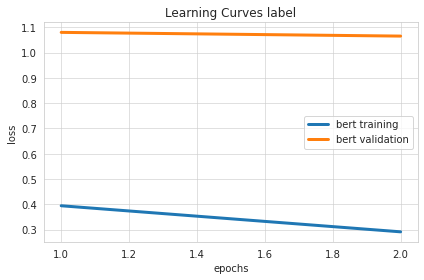

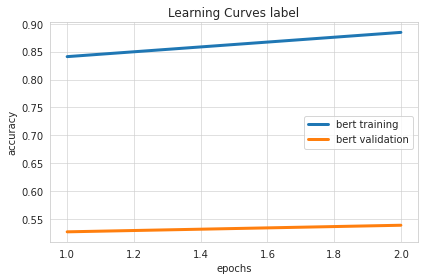

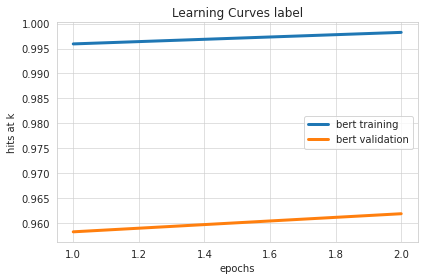

In [ ]:
# visualizing the training results  
learning_curves(train_stats_bert, output_feature_name='label', model_names='bert')

Just a glimpse of the learning curves suggests that BERT requires little to no fine-tuning to perform at par or even better in comparison to the other two models (Parallel CNN, Bi-LSTM) we trained previously, as illustrated in the epochs vs accuracy graph where already at the end of the first epoch the validation accuracy is above 0.5.

We observe that the model achieved a maximum validation accuracy of 53.8% at epoch 2, higher than both the earlier models. To confirm the results obtained on the validation set, let's use some tools built into Ludwig to evaluate and compare BERT with the previous models using the held-out test set.

## **Model Evaluation and Comparisons** 

So far we have seen how different models perform on the training and validation set of SST-5 dataset, but what we really care about is how well do they generalize on the test set. Ludwig provides a very intuitive way for evaluating the models on the test data using the `evaluate` method. The method returns test statistics, predictions for the model evaluated and the output directory where the results get stored. The performance of the models can be compared head to head using the `compare_performance` visualization method that plots the performance of each of the models in the form of bar charts and the predictions can be compared in the form of donut plots using the `compare_classifiers_predictions` visualization method.

Let's first evaluate the models on the test set. It's noteworthy to mention that Colab might remove the models from the memory to free up space, but we can seamlessly load the trained models back from their respective directories with the `load` method that Ludwig provides.     

In [ ]:
parallel_cnn = LudwigModel.load('/content/results/api_experiment_parallel_cnn/model')

test_stats_parallel_cnn, predictions_parallel_cnn, _ = parallel_cnn.evaluate(
  dataset=test_data,
  skip_save_predictions=False,
  collect_predictions=True,
  output_directory='test_results/parallel_cnn'
  )

In [ ]:
bi_lstm = LudwigModel.load('/content/results/api_experiment_bi_lstm/model')

test_stats_bi_lstm, predictions_bi_lstm, _ = bi_lstm.evaluate(
    dataset=test_data,
    skip_save_predictions=False,
    collect_predictions=True,
    output_directory='test_results/bi_lstm'
    )

In [ ]:
bert = LudwigModel.load('/content/results/api_experiment_bert/model')

test_stats_bert, predictions_bert, _ = bert.evaluate(
    dataset=test_data,
    skip_save_predictions=False,
    collect_predictions=True,
    output_directory='test_results/bert'
    )

#### **Head to Head Performance Comparison on Test Set**

Let's now compare the performance of the models on the test set across accuracy and Hits@3 metric in the form of horizontal bar-charts obtained with the `compare_performance` function.

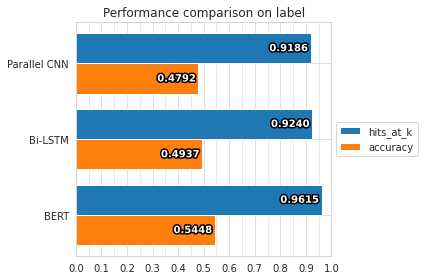

In [ ]:
compare_performance([test_stats_parallel_cnn, test_stats_bi_lstm, test_stats_bert],
                    output_feature_name='label', model_names=['Parallel CNN', 'Bi-LSTM', 'BERT'])

We can see how BERT performs better on the sentiment analysis task as compared to the other two models, with an accuracy of 54.48%.
Even though BERT performs better, there's a trade-off between the accuracy of the predictions and the time required to calculate them. We created a function to obtain 5 shuffled test sets in order to average the elapsed prediction time.

In [ ]:
import time

def shuffled_dataset(test_data, num_shuffles=5):
  test_set = []
  for i in range(num_shuffles):
    test_set.append(test_data.sample(frac=1).reset_index(drop=True))
  return test_set

shuffled_testset = shuffled_dataset(test_data)

In [ ]:
elapsed_time = []
for i in shuffled_testset:
  start = time.time()
  prediction_parallel_cnn, _ = parallel_cnn.predict(dataset=i, batch_size=1)       
  end = time.time()
  elapsed_time.append((end-start)/len(i))

prediction_time_parallel_cnn = sum(elapsed_time)*1000/len(elapsed_time)
print(f'Avg Time Elapsed: {prediction_time_parallel_cnn} ms')

Avg Time Elapsed: 1.2551694757798137 ms


We see that Parallel CNN takes 1.25ms on an average per prediction.

In [ ]:
elapsed_time = []
for i in shuffled_testset:
  start = time.time()
  prediction_bi_lstm, _ = bi_lstm.predict(dataset=i, batch_size=1)       
  end = time.time()
  elapsed_time.append((end-start)/len(i))

prediction_time_bi_lstm = sum(elapsed_time)*1000/len(elapsed_time)
print(f'Avg Time Elapsed: {prediction_time_bi_lstm} ms')

Avg Time Elapsed: 3.696310595689316 ms


The Bi-LSTM takes 3.69ms on an average per prediction.

In [ ]:
elapsed_time = []
for i in shuffled_testset:
  start = time.time()
  prediction_bert, _ = bert.predict(dataset=i, batch_size=1)       
  end = time.time()
  elapsed_time.append((end-start)/len(i))

prediction_time_bert = sum(elapsed_time)*1000/len(elapsed_time)
print(f'Avg Time Elapsed: {prediction_time_bert} ms')

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Avg Time Elapsed: 8.623754945815419 ms


Finally, BERT takes 8.62ms on an average per prediction.


In [ ]:
from tabulate import tabulate

model_names = ['Parallel CNN', 'Bi-LSTM', 'BERT']
test_accuracy = [ 0.4792, 0.4937, 0.5448]
prediction_latency = [prediction_time_parallel_cnn, prediction_time_bi_lstm, prediction_time_bert]

header = ['Model Name', 'Test Accuracy', 'Prediction Latency (ms)']
print(tabulate([*zip(model_names, test_accuracy, prediction_latency)], headers=header, tablefmt='grid'))

+--------------+-----------------+---------------------------+
| Model Name   |   Test Accuracy |   Prediction Latency (ms) |
+==============+=================+===========================+
| Parallel CNN |          0.4792 |                   1.25517 |
+--------------+-----------------+---------------------------+
| Bi-LSTM      |          0.4937 |                   3.69631 |
+--------------+-----------------+---------------------------+
| BERT         |          0.5448 |                   8.62375 |
+--------------+-----------------+---------------------------+


We can distinctly see the difference in how BERT performs better on the sentiment analysis task with an accuracy of 54.48%, although predicting using it takes 8.62ms while predicting using the Bi-LSTM take 3.69ms. Depending on deployment constraints you can choose to run a faster, but less accurate model or a slower but more accurate one.

#### **Comparing Test Set Predictions**

Now, let's visualize the test predictions for each of the models.
After comparing the performance of the models, let's use Ludwig's visualization module to get detailed insights into predictions by comparing them pairwise to understand how much they align or differ using the donut plot generated by the `compare_classifiers_predictions` visualization function. 



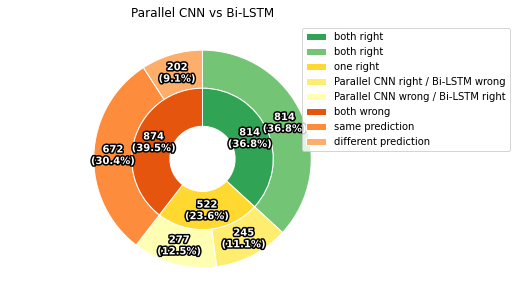

In [ ]:
metadata_parallel_cnn = load_json('/content/results/api_experiment_parallel_cnn/model/training_set_metadata.json')

compare_classifiers_predictions([np.array(predictions_parallel_cnn['label_predictions'], dtype=int),
                                np.array(predictions_bi_lstm['label_predictions'], dtype=int)],
                                ground_truth=np.array(test_data['label']), labels_limit=5,
                                output_feature_name='label', metadata=metadata_parallel_cnn,
                                model_names=['Parallel CNN', 'Bi-LSTM'])

The inner donut illustrates a generic estimate of the models' predictions - both correct (36.8%), both incorrect (39.5%), either of them correct (23.6%). The outer donut represents a detailed outline of the inner estimates - both correct (36.8%), both incorrect yet same (30.4%) or different (9.1%), Parallel CNN being correct and Bi-LSTM being incorrect (11.1%) and vice-versa (12.5%). 

The plot shows that the model behaves similarly because of the big green and red areas, and that the bi-LSTM outperforms the Parallel CNN, although there's still an 11% of data points where the Parallel CNN are correct and the bi-LSTM ones are wrong.

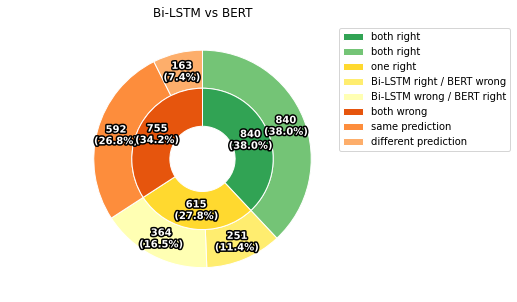

In [ ]:
metadata_bert = load_json('/content/results/api_experiment_bert/model/training_set_metadata.json')

compare_classifiers_predictions([np.array(predictions_bi_lstm['label_predictions'], dtype=int),
                                np.array(predictions_bert['label_predictions'], dtype=int)],
                                ground_truth=np.array(test_data['label']), labels_limit=5,
                                output_feature_name='label', metadata=metadata_bert,
                                model_names=['Bi-LSTM', 'BERT'])

Similarly, from the above donut plot, we can compare Bi-LSTM's and BERT's predictions. According to the plot, a generic estimate of the models' predictions - both correct (38.0%), both incorrect (34.2%), either of them correct (27.8%) and a detailed outline of the generic estimates - both correct (38.0%), both incorrect yet same (26.8%) or different (7.4%), Bi-LSTM being correct and BERT being incorrect (11.4%) and vice-versa (16.5%). 

In this case, the predictions of the models are more diverse with a larger yellow area, but also in this case, despite BERT being more accurate, there's still an 11% of data points that the bi-LSTM predicts correctly and BERT does not.

## Testing model's predictions on Unseen data

Let's use the model we evaluated as most accurate and most generalizable to predict the sentiment of a movie review we made up.

In [ ]:
# text for predicting
texts = ["This movie is amazing!", 
         "I hated the movie so much.", 
         "The special effects were ok, but the story was nothing special."]

# converting the text into dataframes
texts_df = pd.DataFrame({'text': texts})

# predicting using our best model
predictions, _ = bert.predict(dataset=texts_df)

# ids to labels
labels = []
for prediction in predictions['label_predictions']:
  labels.append(idx2class[int(prediction)])

# processing the ids, labels and text into a single dataframe
predictions_df = texts_df.assign(class_id=predictions['label_predictions'], class_label=labels)

pd.set_option('display.max_colwidth', None)  
predictions_df

,text,class_id,class_label
0,This movie is amazing!,4,very positive
1,I hated the movie so much.,0,very negative
2,"The special effects were ok, but the story was nothing special.",1,negative


Our BERT Ludwig model predicts the correct sentiment of those made-up reviews.

## **Model Tunning (Hyperparameter Optimization)**

#### **Setup**

Now let's see how can we easily run an hyperparameter optimization in Ludwig to figure out the best hyperparameters for the RNN model we trained before.

Let's first install a few more packages that we will need for Ludwig's hyperopt module.





In [ ]:
!pip install --quiet ludwig[hyperopt]

     |████████████████████████████████| 92kB 8.4MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
     |████████████████████████████████| 163kB 40.2MB/s 
     |████████████████████████████████| 174kB 23.8MB/s 
     |████████████████████████████████| 153kB 41.8MB/s 
     |████████████████████████████████| 1.8MB 47.3MB/s 
     |████████████████████████████████| 71kB 12.0MB/s 
     |████████████████████████████████| 204kB 59.5MB/s 


In order to use the hyperopt functionality we need to write a new configuration which includes an hyperopt section in which we declare to Ludwig the specification of the hyperparameter optimization we want to run.

If you want to change the hyperparams and the search space, look [here](https://ludwig.ai/user_guide/#hyper-parameter-optimization) for more details.

#### **What hyperparameters can we optimize and what do they do?**

Below are some of the main hyperparameters that you can consider optimizing for

>**Learning rate:** tells the model how much to update the weights $(0.0 \le \kappa \le 1.0)$.
- If learning rate is too large, $\kappa \rightarrow 1.0$, then gradient descent may never converge to a minimum.
- If learning rate is too small, $\kappa \rightarrow 0.0$, then the model will take too long to train and may end up stuck in local minima.

>**State size:** the size of the hidden state of the RNN.
- Larger state size will allow each RNN cell to pass along more information, but will increase computation time.

>**RNN cell type:** 
- **Vanilla RNN:** processes input and hidden state with a single weight matrix. The vanilla RNN cell has issues with exploding and vanishing gradients which can be solved with the other cell architectures below
- **Gated Reccurent Units (GRU):** GRU cells include a forget gate that updates the hidden state by removing unnecessary information.
- **Long Short Term Memory (LSTM):** LSTM cells use an additional cell state that is passed between cells along with the hidden state. LSTMs have 3 gates: input gate, forget gate, and output gate which are used to update the cell state and calculate new hidden states.

>**Number of encoder layers:** more layers may result in higher accuracy but will also he more computationally expensive and may lead to overfitting.

>**Bidirectionality:** 
- **One directional sequence models** generally process the input in first to last order.
- **Bidirectional sequence models** act like a one directional sequence model, with the addition of a second hidden layer that processes the input in the order of last to first.



#### **Adding Hyperparameter Optimization to a Ludwig Configuration**

In [ ]:
config = {
    'input_features': [
        {'name': 'text', 
         'type': 'text', 
         'level': 'word', 
         'encoder': 'rnn',
         'bidirectional': True,
         'pretrained_embeddings': '/content/glove/glove.6B.300d.txt',
         'embedding_size': 300,
         'preprocessing': {
            'word_vocab_file': '/content/glove/glove.6B.300d.txt'
         }
        }
    ],
    'output_features': [
        {'name': 'label', 'type': 'category'}
    ],
    'training': {
        'decay': True,
        'learning_rate': 0.001,
        'validation_field': 'label',
        'validation_metric': 'accuracy'
    },
    'hyperopt': {
        'goal':'maximize',
        'output_feature': 'label',
        'metric': 'accuracy',
        'split': 'validation',
        'parameters': {
            'training.learning_rate': {
                'type': 'float',
                'low': 0.00001,
                'high': 0.001,
                'steps': 3,
                'scale': 'log'
            },
            'utterance.state_size':{
                'type': 'int',
                'low': 300,
                'high': 900,
                'steps': 3
            },
            'utterance.cell_type': {
                'type': 'category',
                'values': ['rnn', 'gru', 'lstm']
            },
            'utterance.num_layers': {
                'type': 'int',
                'low': 1,
                'high': 5
            },
        },
        'sampler': {
            'type': 'random',   
            'num_samples': 80  # recommended to use 20 * number of hyperparameters
        },
        'executor': {
            'type': 'serial'
        }
    }
}

Finally, we call the hyperopt API with our dataset and configuration. When the hyperopt is complete, it will output a *hyperopt_statistics.json* file into the output directory. 

The hyperopt API uses the configuration we defined above to perform hyperparamter optimization
> **Goal**: maximize or minimize the metric

> **Output feature**: the name of the output feature to optimize on (defined in output features configuration)

> **Metric**: the metric to optimize for (i.e. accuracy or loss)
-  There may be other metrics to choose from depending on the output featuree type

> **Split**: which data split to optimize on (i.e. training, validation, or test data)
- Common practice is to pick hyperparameters based on validation set performance

> **Parameters**: defines which hyperparameters we want to use and ranges of values to search in

> **Sampler**: defines number of samples and the type of sampler

> **Executor**: can choose between serial, parallel, or fiber depending on execution environment

For more information on hyperopt visit the [Ludwig User Guide](https://ludwig-ai.github.io/ludwig-docs/user_guide/#hyper-parameter-optimization)

**Consideration:** Hyperparameter optimization may take several hours, even on GPU runtimes.

In [ ]:
# load Hyperparameter optimizer
from ludwig.hyperopt.run import hyperopt
# performs optimization
hyperopt(
    config=config,
    training_set=train_data,
    validation_set=validation_data,
    test_set=test_data,
    output_directory="hyperopt_results",
    skip_save_progress=True, 
    skip_save_model=True,
    skip_save_processed_input=True
)

#### **Visualizing the Hyperparameter Optimization Results**

Let's now generate some plots of the hyperopt results

We will use the *programmatic api* but you can also perform the same task through the command line interphase, i.e. terminal, with the following command:

```bash
!ludwig visualize -v hyperopt_report -hs hyperopt_results/hyperopt_statistics.json -od ./plots -ff png
```

In [ ]:
from IPython.display import Image
from ludwig.visualize import hyperopt_report_cli

hyperopt_report_cli(
    'hyperopt_results/hyperopt_statistics.json',
    output_directory='./plots',
    file_format='png'
)

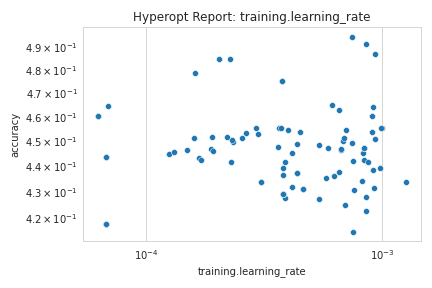

In [ ]:
Image('/content/plots/hyperopt_training.learning_rate.png')

> **Hyperopt Report: learning rate**
- The general trend seems to be that smaller learning rates perform better on average
- Our three best performing samples have learning rates slightly less than 10<sup>-3</sup> 

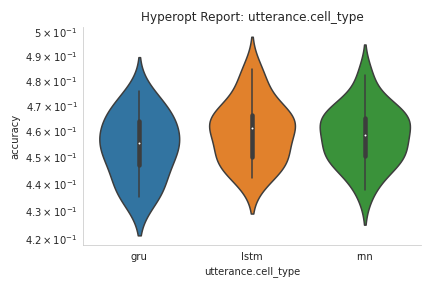

In [ ]:
Image('/content/plots/hyperopt_utterance.cell_type.png')

> **Hyperopt Report: cell type**
- The LSTM cell seems to have the best average performance as indicated by the white dot and the vertical black line
- The RNN cell performs slightly better than the GRU cell on average

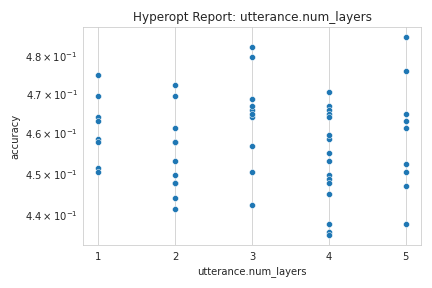

In [ ]:
Image('/content/plots/hyperopt_utterance.num_layers.png')

> **Hyperopt Report: num layers**
- There doesn't seem to be any obvious trends, although our best performing samples have used 3 or 5 layers
- Either this hyperparameter does not have a significant effect on performance or that we need more samples in order to observe a trend

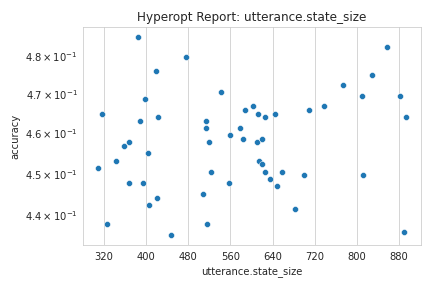

In [ ]:
Image('/content/plots/hyperopt_utterance.state_size.png')

> **Hyperopt Report: state size**
- State sizes around the middle (600) seem to have very consistent performance, while state sizes closer to the edges (300 and 900) have a greater variation in results

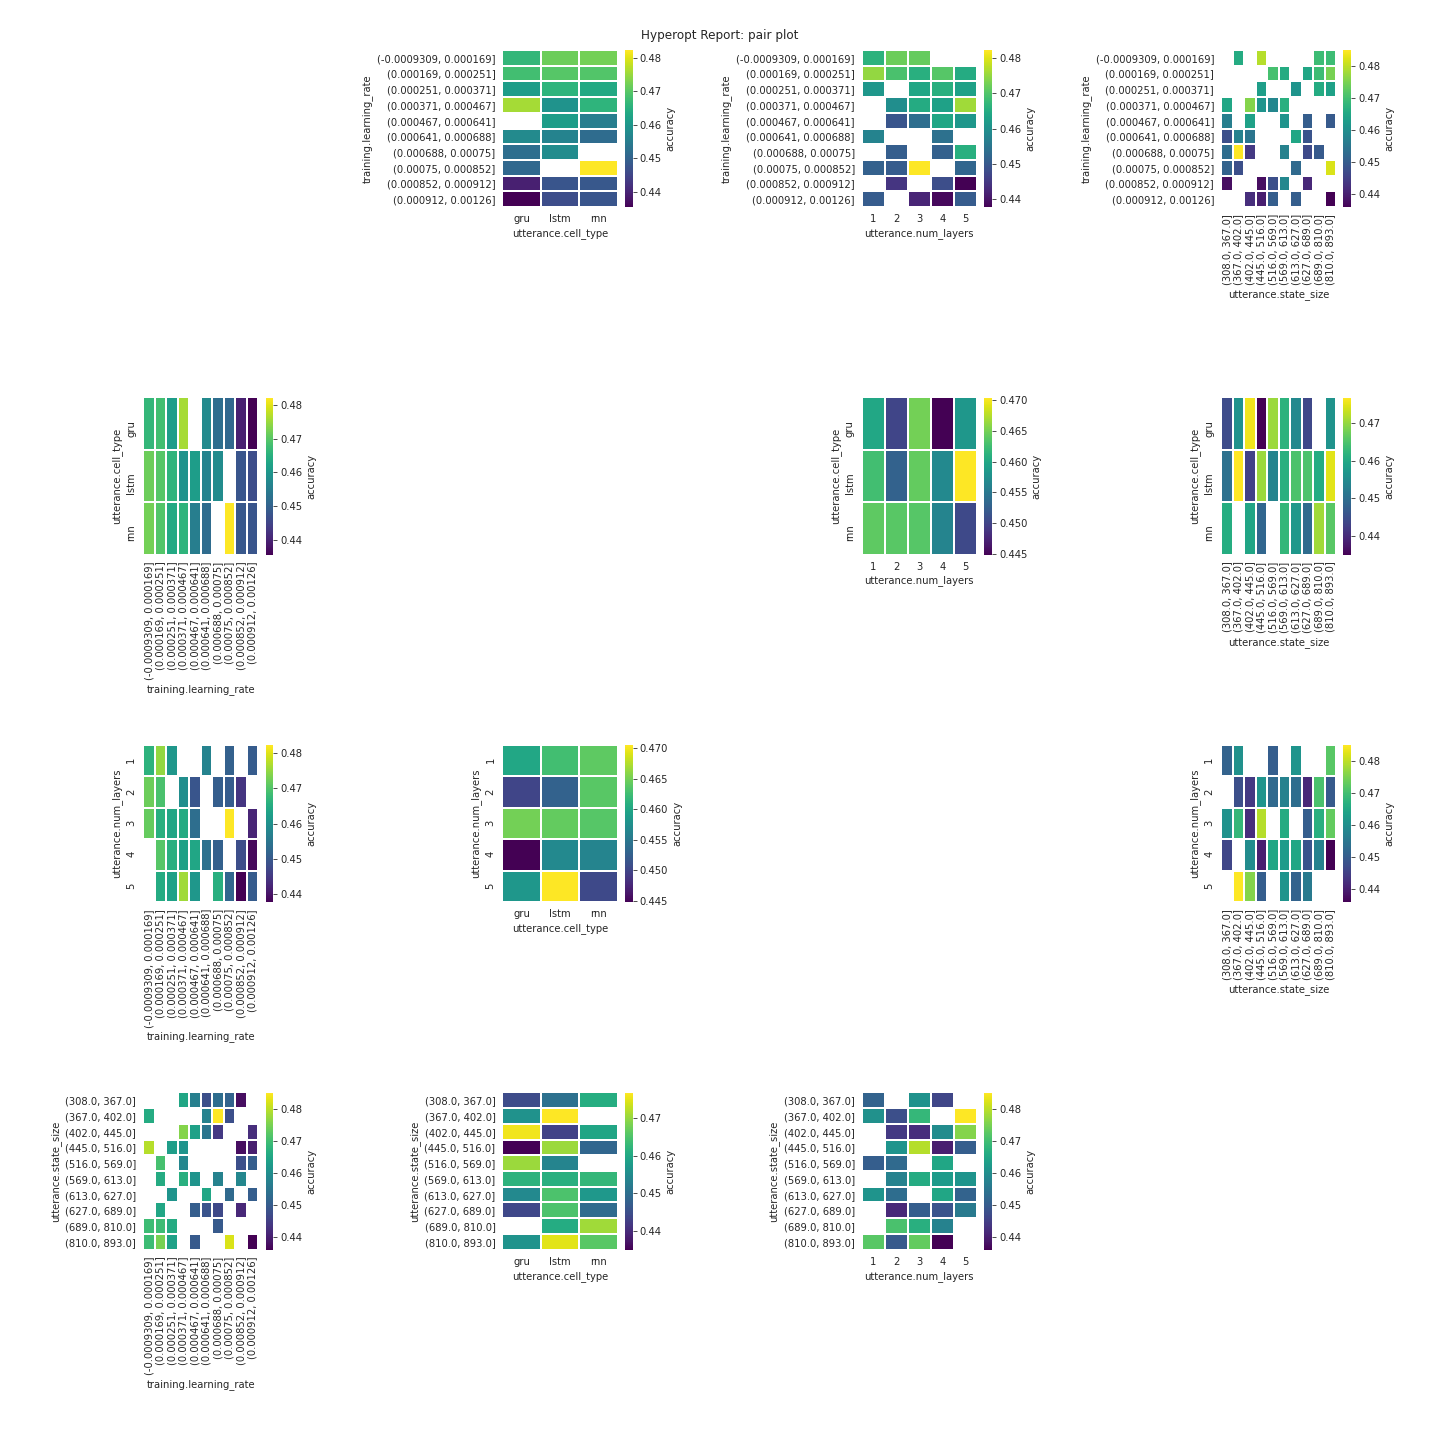

In [ ]:
Image('/content/plots/hyperopt_pair_plot.png')

> **Hyperopt Report: pair plot**
- The pair plot gives us an overview of how different pairs of hyperparameters affect performance
- Color scheme ranges from yellow (better performance) to blue (worse performance)

#### **Visualizing High-Dimensional Data**

We can can also use a **hiplot** which helps us visualize high-dimensional data in an interactive webpage (.html file)

A hiplot displays each hyperparameter as a vertical axis and each sample passes through each vertical axis at the value it is correlated with

The programmatic api is shown, but you can also use the cli with the following command

```
!ludwig visualize -v hyperopt_hiplot -hs hyperopt_results/hyperopt_statistics.json -od ./plots -ff png
```


In [ ]:
from ludwig.visualize import hyperopt_hiplot_cli

hyperopt_hiplot_cli(
    'hyperopt_results/hyperopt_statistics.json',
    output_directory='./plots'
)


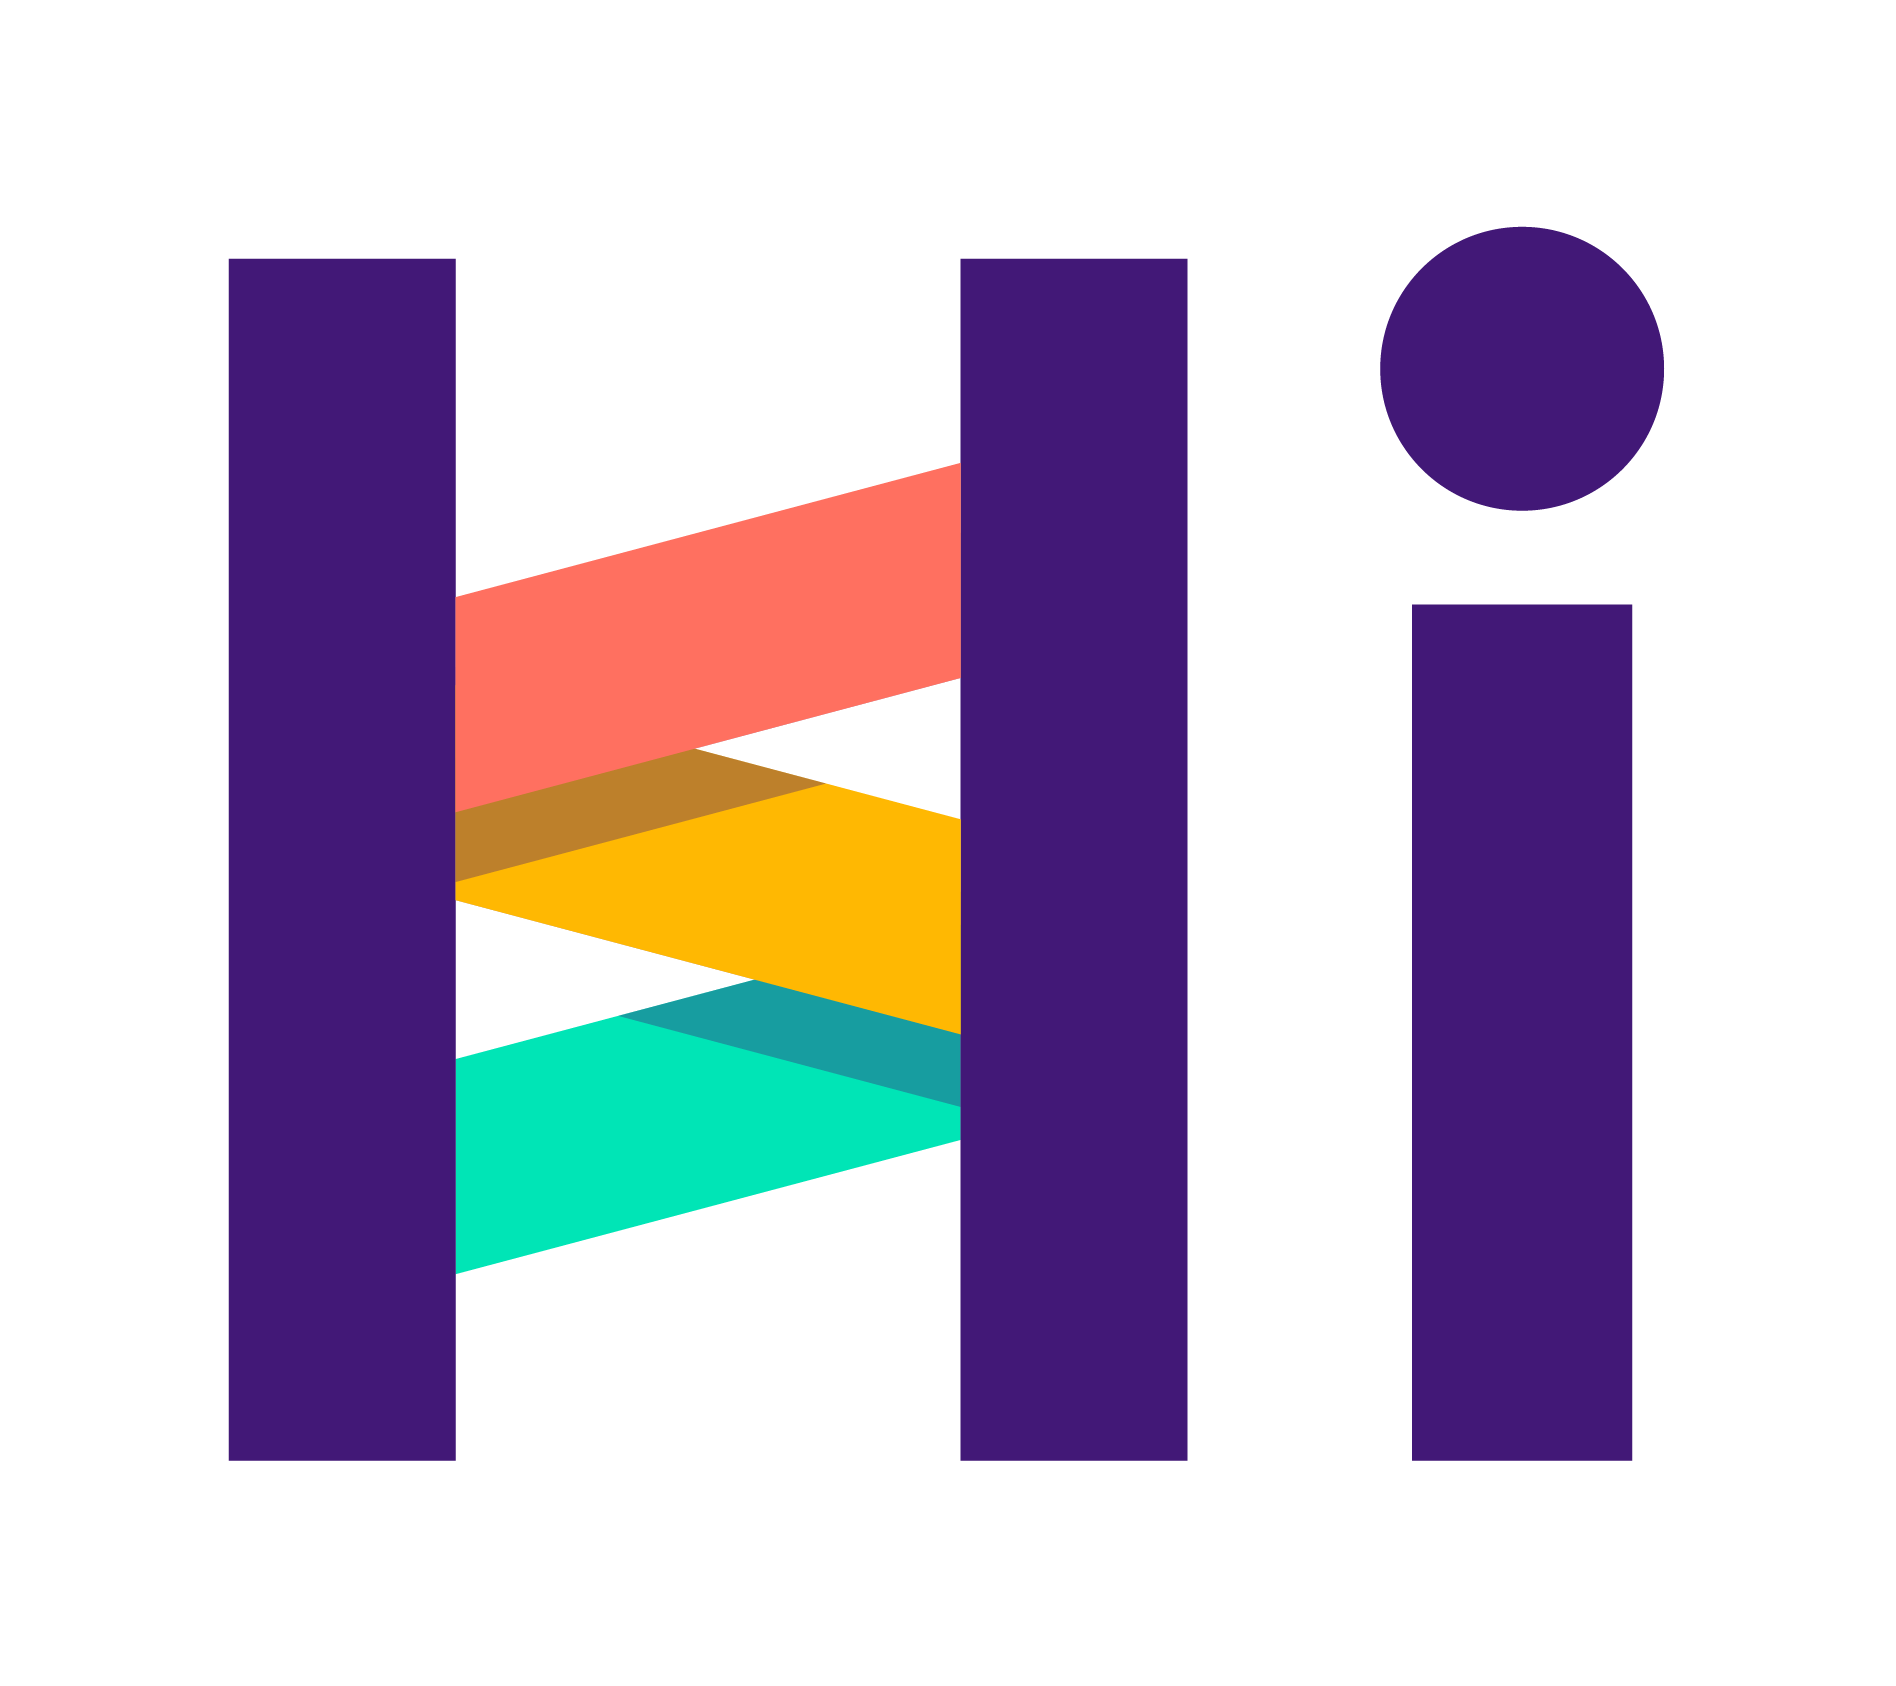

In [ ]:
from IPython.display import HTML
HTML(filename='/content/plots/hyperopt_hiplot.html')

From the hiplot we can see that the hyperparameter combination that gave us the best performance was:
- learning rate: 0.0007445273631496333			
- encoder layers: 5
- cell type: lstm
- state size: 385

We achieved a best accuracy of 49.46% which is better than the 45.7% accuracy achieved in the original ["Recursive Deep Models for Semantic Compositionality
Over a Sentiment Treebank"](https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf) paper by Socher et al.

This result gives similar hyperparameters and performance to the default bidirectional lstm used above which make sense because the default model used optimal hyperparameters found in literature.

# Conclusion

Over the course of this Colab we sought to highlight two key features of Ludwig -- (1) the ease with which state-of-the-art models can be trained, and (2) how Ludwig simplifies the process of model selection, tuning, and optimization. Although we did not have enough time to cover it, Ludwig can also be used to deploy models *in the wild*, and can be an integratable part of any AI system or machine learning pipeline.

Ludwig can be used for a variety of deep learning tasks, including NLP, computer vision, and speech -- to name but a few. We encourage you to visit some of the following links to learn more and to become engaged with the Ludwig open source community. We aim to make deep learning free and accessible to all. We hope you'll join us.

* To learn more about Ludwig, check out the [documentation](http://ludwig.ai).

* Get involved in the Ludwig [open source community](http://ludwig.ai/community).

* Follow Ludwig on [twitter](https://twitter.com/ludwig_ai) to stay afloat with all news and developments.

*Copyright 2021 Ludwig AI*

*Licensed under the Apache License, Version 2.0 (the "License");*

```
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

